# Putting the Object Back into Video Object Segmentation
# Colab Demo

[[arXiv]](https://arxiv.org/abs/2310.12982) [[PDF]](https://arxiv.org/pdf/2310.12982.pdf) [[Code]](https://github.com/hkchengrex/Cutie) [[Project Page]](https://hkchengrex.github.io/Cutie/)

![title](https://camo.githubusercontent.com/84482c6f65f93339699387c6880640bf5213583ceca2f5658c423dc1d68ab8a9/68747470733a2f2f696d6775722e636f6d2f364b3742675a372e706e67)

![overview](https://camo.githubusercontent.com/53c8662cecfbd61e1e06d08cfe086333cbcb365170ad56f6a62e9d55aa7a918b/68747470733a2f2f696d6775722e636f6d2f707835673433372e6a7067)

You can make a copy of this notebook to change the input video or mask.

In [1]:
!nvidia-smi

import torch

if torch.cuda.is_available():
  print('Using GPU')
  device = 'cuda'
else:
  print('CUDA not available. Please connect to a GPU instance if possible.')
  device = 'cpu'

Thu Nov 28 13:20:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Get our code and install prerequisites

In [2]:
!git clone https://github.com/hkchengrex/Cutie.git
%cd Cutie
!pip install -e .

Cloning into 'Cutie'...
remote: Enumerating objects: 609, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 609 (delta 170), reused 160 (delta 132), pack-reused 374 (from 1)
Receiving objects: 100% (609/609), 2.84 MiB | 4.20 MiB/s, done.
Resolving deltas: 100% (285/285), done.
/content/Cutie
Obtaining file:///content/Cutie
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/cheind/py-thin-plate-spline to /tmp/pip-install-lm2nptwu/thinplate_19b34eac74d94fa5a0531e98fb17c161
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-thin-plate-spline /tmp/pip-install-lm2nptwu/thinplate_19b34eac74d94fa5a0531e98fb17c161
  Resolved https://github.com/cheind/py-thin-plate-spli

# Then restart the runtime.

# Download the pretrained model



In [1]:
%cd /content/Cutie
!python cutie/utils/download_models.py

/content/Cutie


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install hydra-core --upgrade


# Basic setup

In [3]:
%cd /content/Cutie/

from os import path
import logging
from omegaconf import DictConfig
import hydra
from hydra.core.hydra_config import HydraConfig
from omegaconf import open_dict
from hydra import compose, initialize

import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image

from cutie.inference.data.vos_test_dataset import VOSTestDataset
from cutie.inference.data.burst_test_dataset import BURSTTestDataset
from cutie.model.cutie import CUTIE
from cutie.inference.inference_core import InferenceCore
from cutie.inference.utils.results_utils import ResultSaver, make_zip
from cutie.inference.utils.burst_utils import BURSTResultHandler
from cutie.inference.utils.args_utils import get_dataset_cfg

from tqdm import tqdm


from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()

with torch.inference_mode():
  initialize(version_base='1.3.2', config_path="cutie/config", job_name="eval_config")
  cfg = compose(config_name="eval_config")

  with open_dict(cfg):
    cfg['weights'] = './weights/cutie-base-mega.pth'

  data_cfg = get_dataset_cfg(cfg)

  # Load the network weights
  cutie = CUTIE(cfg).cuda().eval()
  model_weights = torch.load(cfg.weights)
  cutie.load_weights(model_weights)

/content/Cutie


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 442MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 282MB/s]
<ipython-input-3-955f61fc2041>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitl

# Load some data

(Source: https://www.youtube.com/watch?v=FTcjzaqL0pE)

In [4]:

# 파일 이름 지정
video_name = 'red fox.mp4'
mask_name = 'redfox_frame1.jpg'
#/content/Cutie/examples/masks/rabbit/rabbit1_mask.png
#경로 설정
video_path = f'/content/drive/MyDrive/ComVi/{video_name}'
image_path = f'/content/drive/MyDrive/ComVi/{mask_name}'

"\n# 파일 이름 지정\nvideo_name = 'rabbit1.mp4'\nmask_name = 'rabbit_1_mask2.jpg'\n#/content/Cutie/examples/masks/rabbit/rabbit1_mask.png\n#경로 설정\nvideo_path = f'/content/drive/MyDrive/{video_name}'\nimage_path = f'/content/drive/MyDrive/{mask_name}'\n"

# Preview the video and first-frame annotation

The first frame mask is a PNG with a color palette.

In [5]:
from IPython.display import HTML
from base64 import b64encode

data_url = "data:video/mp4;base64," + b64encode(open(video_path, 'rb').read()).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

In [6]:
import IPython.display
image_path = '/content/drive/MyDrive/ComVi/redfox_frame1.jpg'
IPython.display.Image(image_path, width=400)

## Convert the mask to a numpy array

In [25]:
from PIL import Image
import numpy as np

mask_path = '/content/drive/MyDrive/ComVi/redfox_mask1.jpg'
# Use Image.open to open the image file
mask = np.array(Image.open(mask_path))
valid_values = [1, 2, 3]
mask = np.isin(mask, valid_values).astype(np.uint8)

In [26]:
import os

video_name = '/content/drive/MyDrive/ComVi/red fox.mp4'

# Check if the video file exists
if not os.path.exists(video_name):
    print(f"Error: Video file '{video_name}' does not exist.")
else:
    print(f"Video file '{video_name}' found.")


Video file '/content/drive/MyDrive/ComVi/red fox.mp4' found.


# Propagte frame-by-frame

In [32]:
import cv2
from gui.interactive_utils import image_to_torch, torch_prob_to_numpy_mask, index_numpy_to_one_hot_torch, overlay_davis
import numpy as np
import torch

device = 'cuda'
torch.cuda.empty_cache()
'''
# 마스크에서 객체 개수 계산 (예시: 마스크에 고유한 값에서 배경(0)을 제외한 개수)
num_objects = len(np.unique(mask)) - 1  # 배경 제외
'''
num_objects = int(input("마스크에 포함된 객체의 개수를 입력하세요: "))

print('num_objects :',num_objects) #이거 직접입력 기능 넣으면 좋겟다

processor = InferenceCore(cutie, cfg=cfg)
cap = cv2.VideoCapture(video_name)

# You can change these two numbers
frames_to_propagate = 200
visualize_every = 20

current_frame_index = 0


마스크에 포함된 객체의 개수를 입력하세요: 2
num_objects : 2


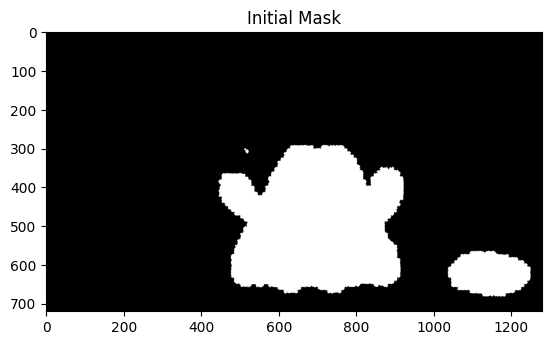

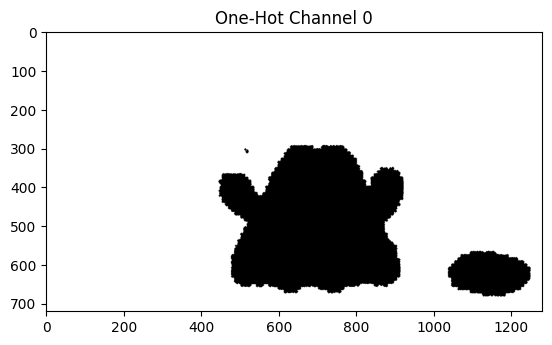

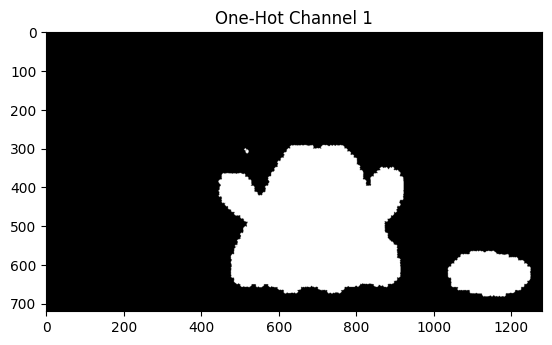

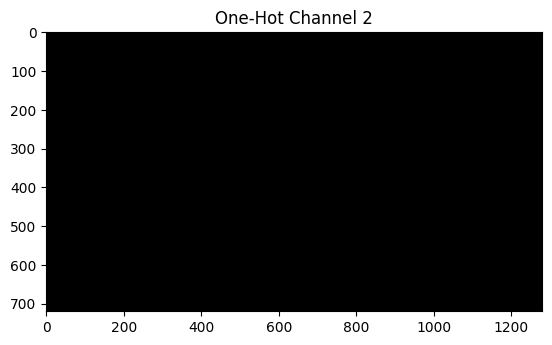

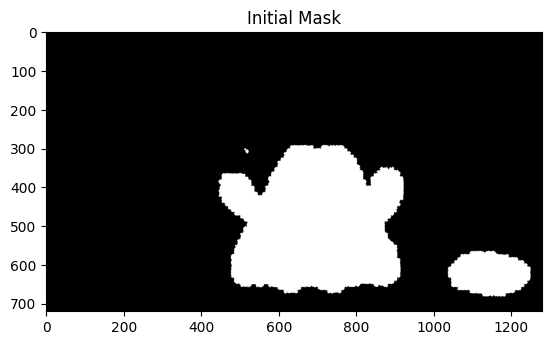

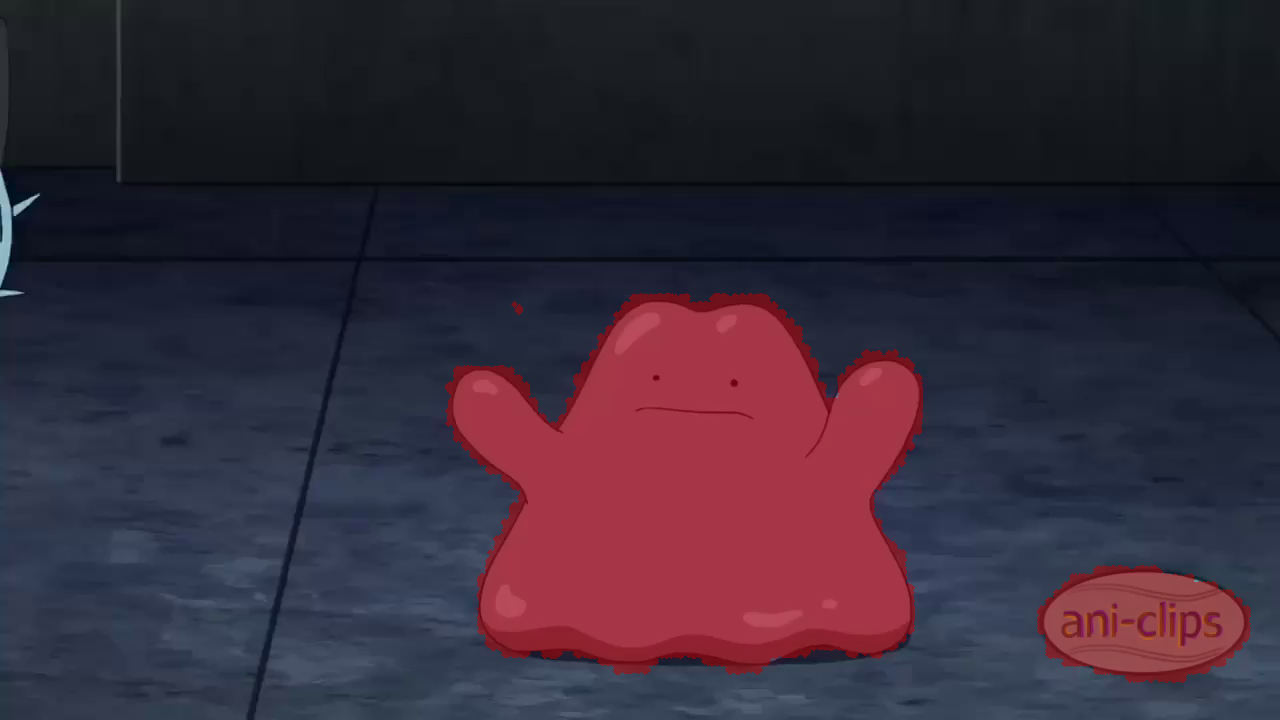

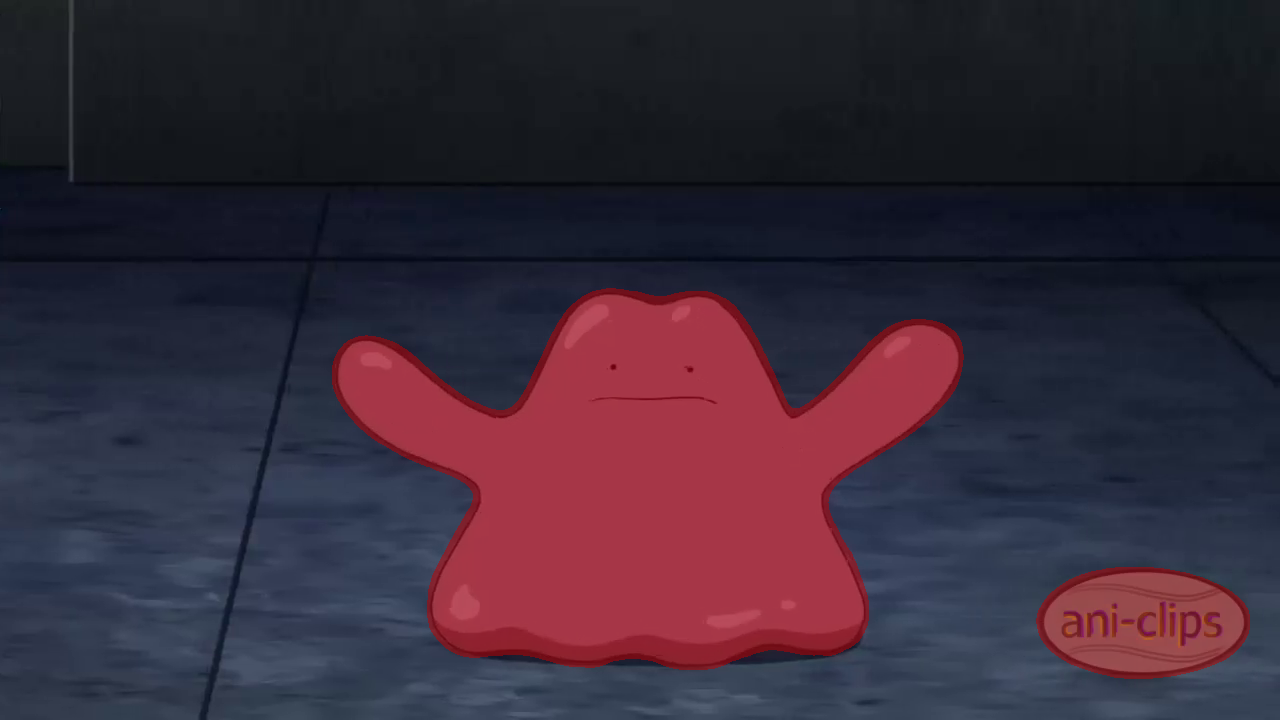

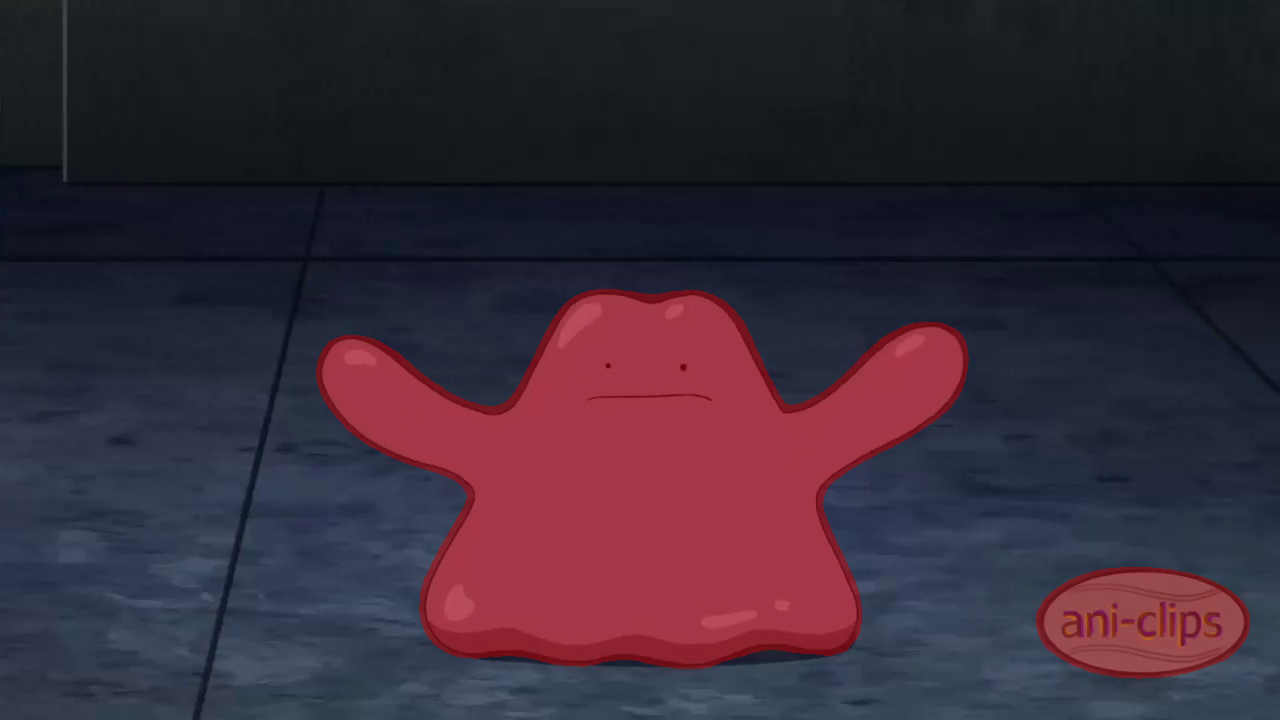

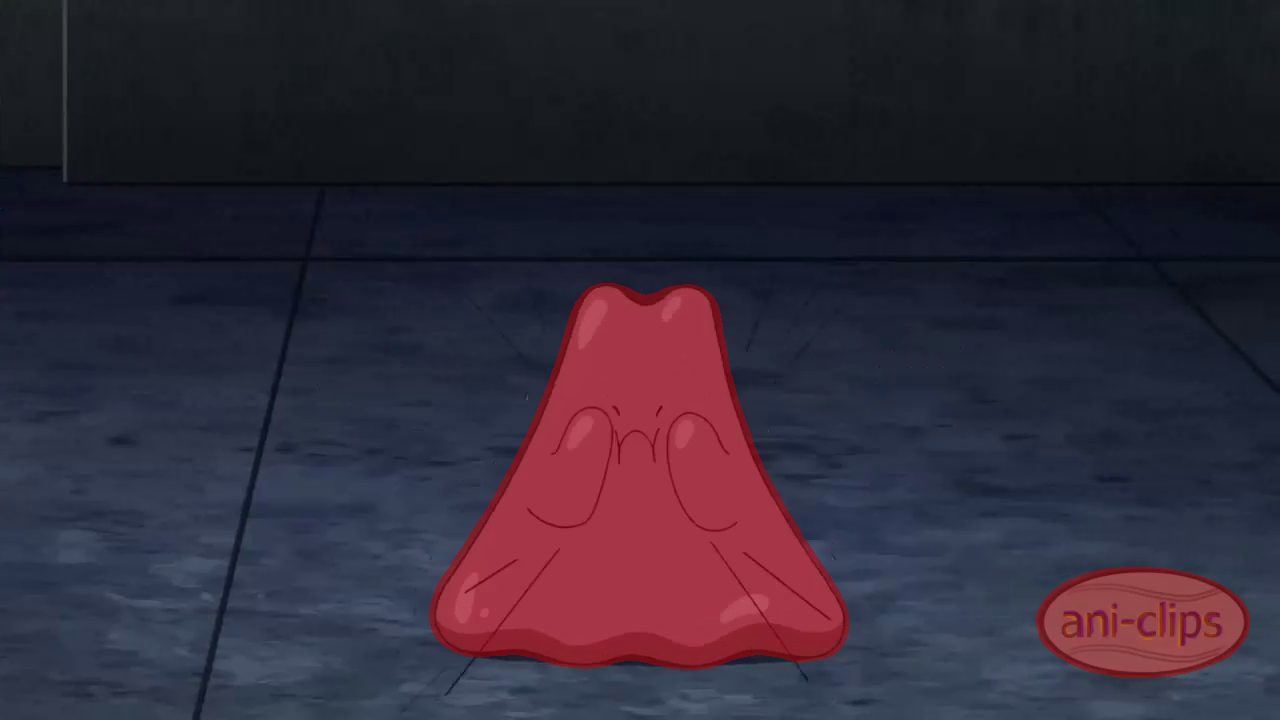

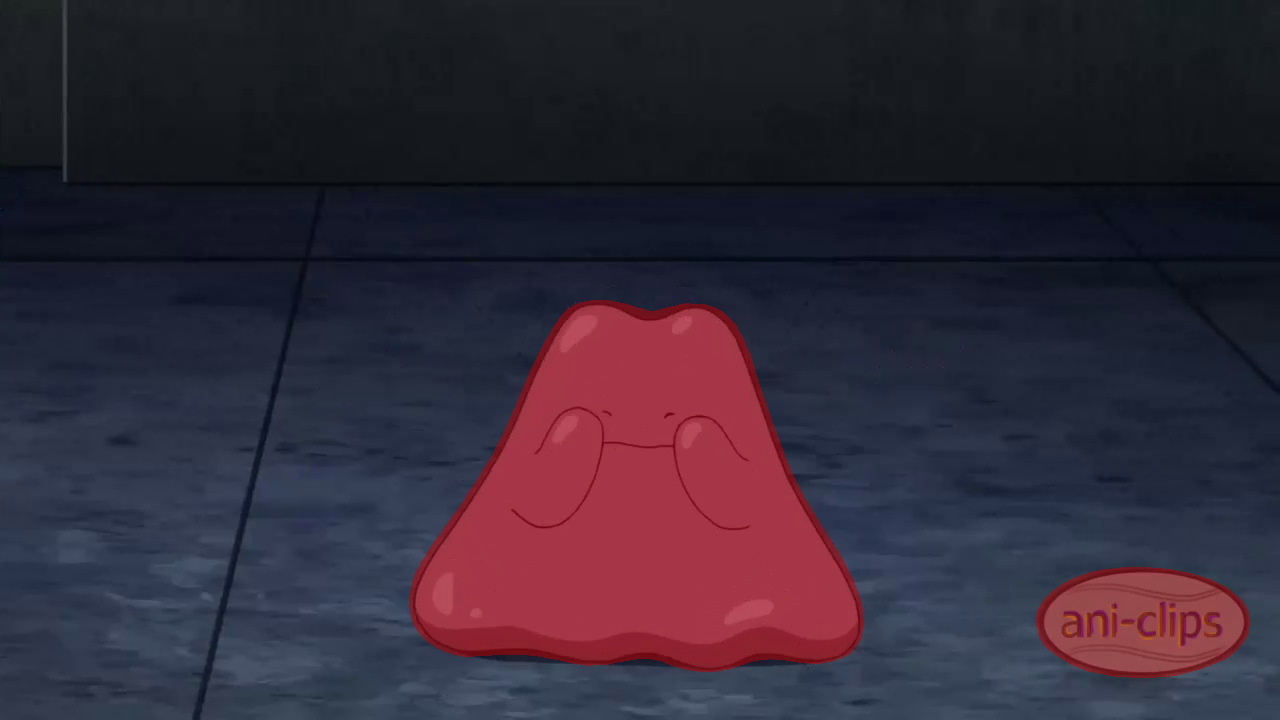

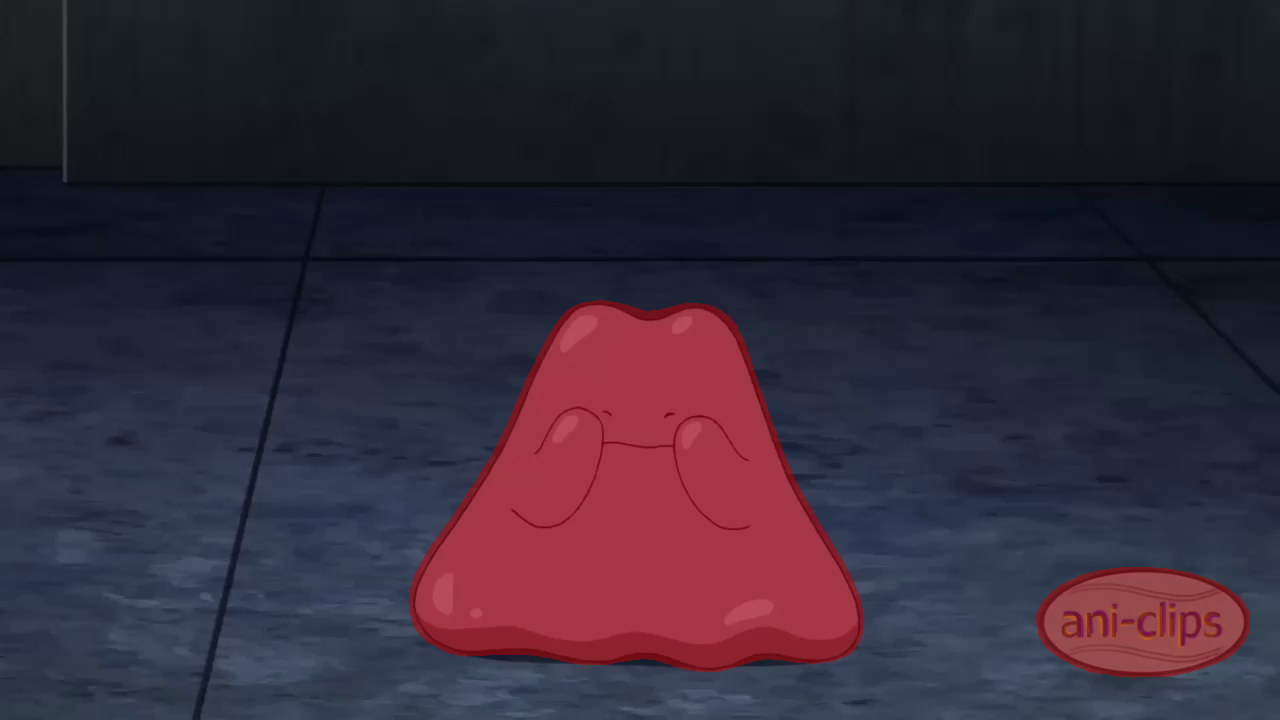

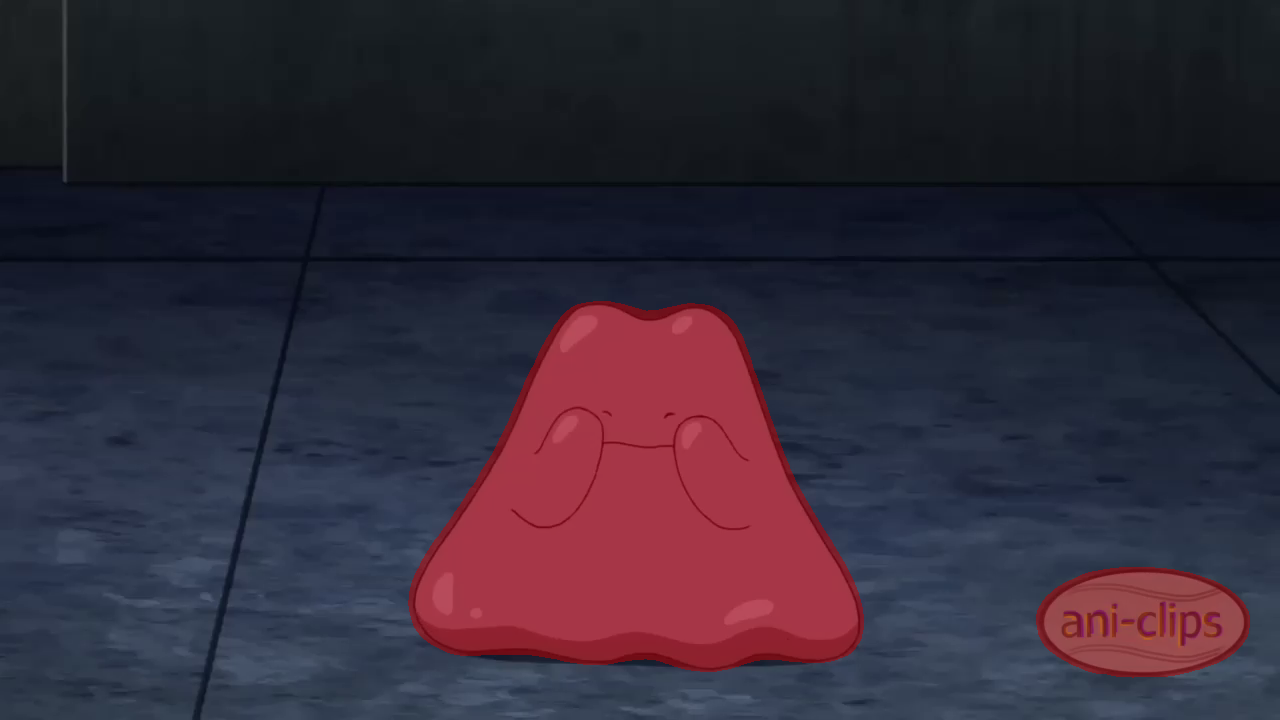

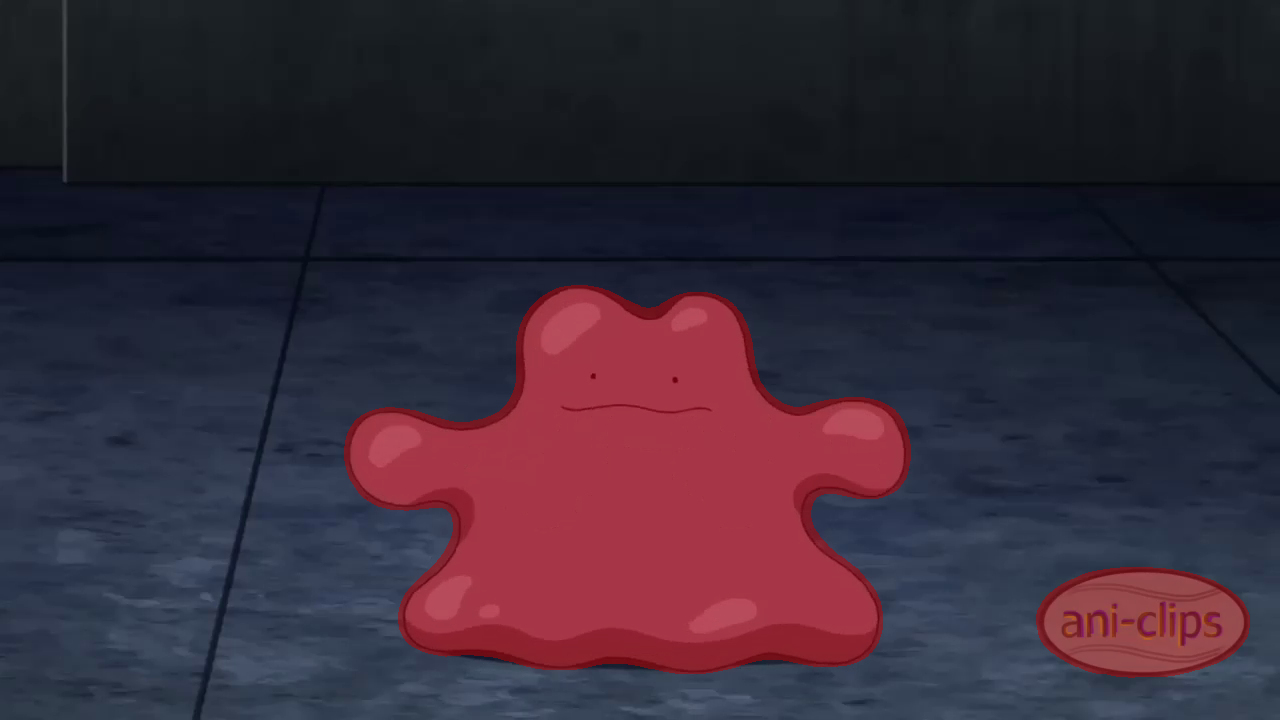

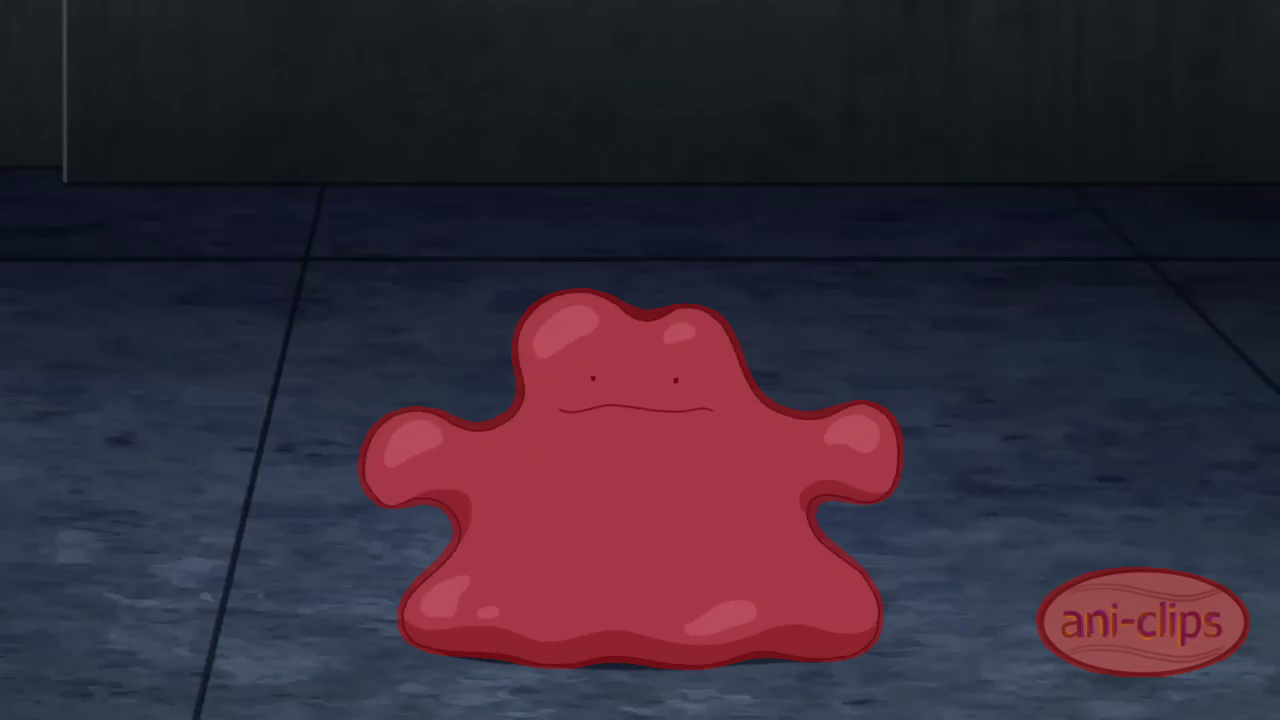

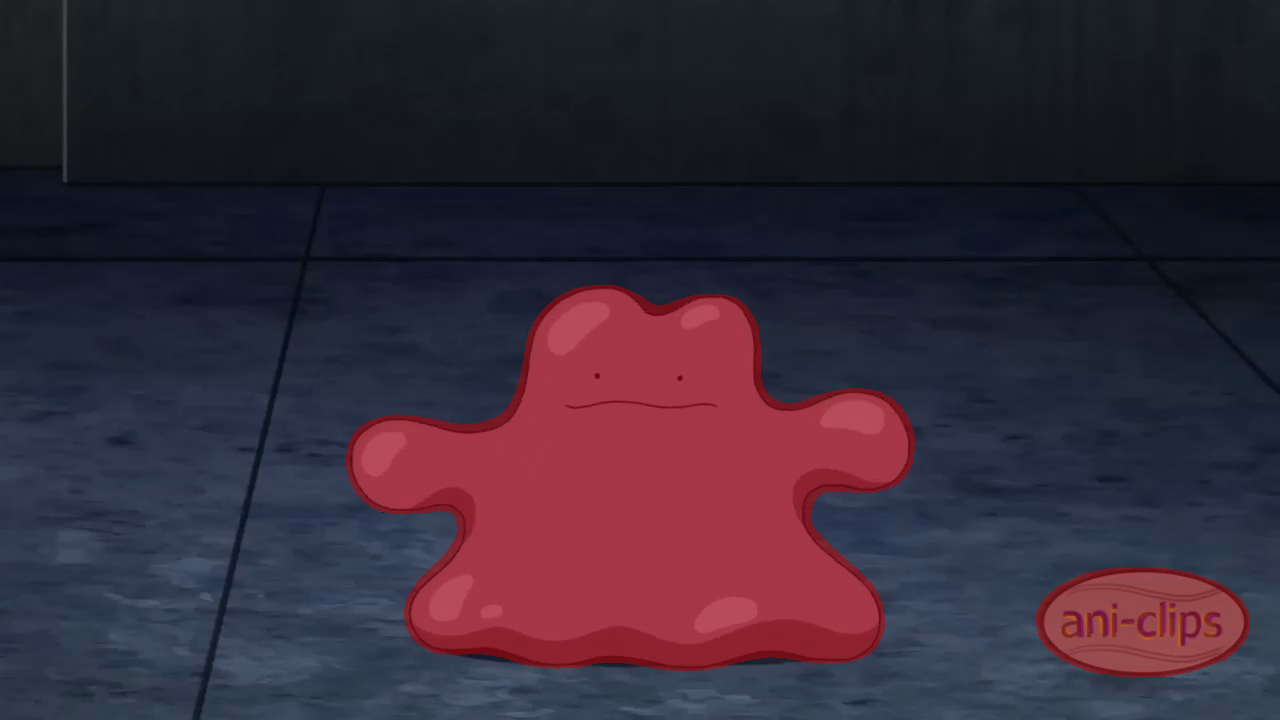

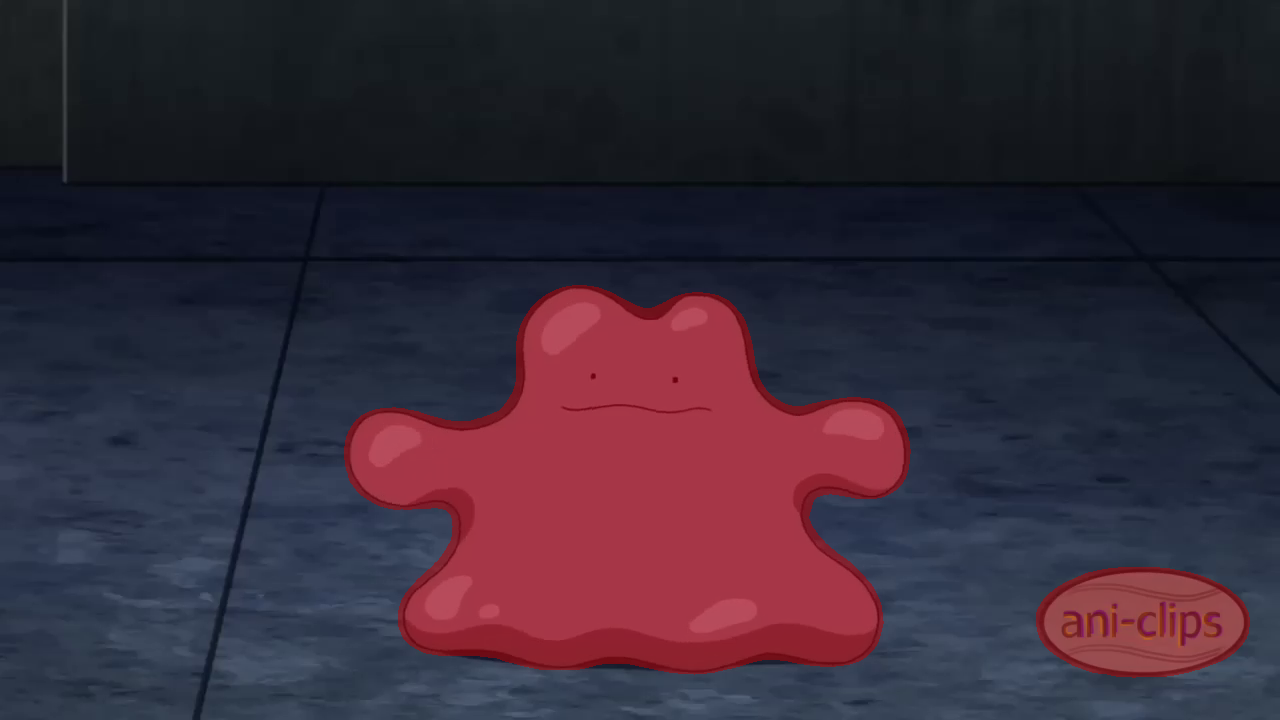

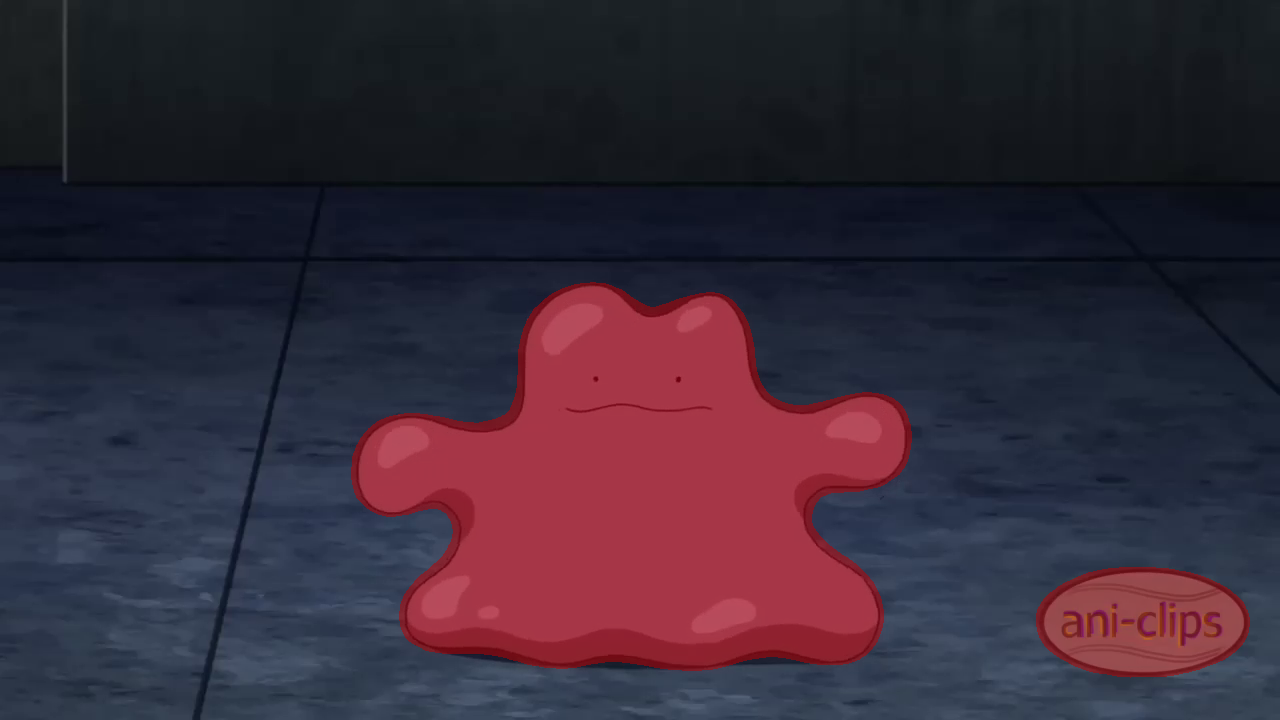

In [33]:
import torch
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage import binary_dilation  # 마스크 확장에 사용
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import logging

# 로깅 설정
logging.basicConfig(level=logging.INFO)

# 비디오 및 마스크 경로
video_path = '/content/drive/MyDrive/ComVi/metamon.mp4'
mask_path = '/content/drive/MyDrive/ComVi/metamon_mask1.jpg'

# 마스크 파일을 그레이스케일로 읽기
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # 마스크는 그레이스케일로 읽어야 함

# 마스크가 0과 255로 이루어져 있을 때, 255를 1로 변경 (이진 마스크 처리)
mask = mask / 255

# 마스크 확장 (경계 확장)
mask = binary_dilation(mask, iterations=3).astype(mask.dtype)

# 시각화: 초기 마스크 확인
plt.imshow(mask, cmap='gray')
plt.title("Initial Mask")
plt.show()

# PyTorch 모델에서 사용할 수 있도록 마스크를 텐서로 변환 (NumPy에서 PyTorch로)
mask_torch = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W) 형식으로 변환

# One-Hot 인코딩 수행
mask_torch_one_hot = index_numpy_to_one_hot_torch(mask, num_objects + 1).to(device)

# One-Hot 변환된 텐서 확인 및 시각화
logging.info(f"Mask Tensor Shape (One-Hot): {mask_torch_one_hot.shape}")  # (C, H, W)
for i in range(mask_torch_one_hot.shape[0]):  # 각 채널 확인
    plt.imshow(mask_torch_one_hot[i].cpu().numpy(), cmap="gray")
    plt.title(f"One-Hot Channel {i}")
    plt.show()

# 초기 비디오 캡처
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("비디오 파일을 열 수 없습니다.")

# 비디오 저장 설정
output_video_path = "/content/drive/MyDrive/ComVi/output_metamon.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
frame_height, frame_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# 프레임 인덱스 및 예측 처리
current_frame_index = 0
frames_to_propagate = 100  # 예시: 100프레임까지만 처리
visualize_every = 5  # 5프레임마다 시각화

# 프레임을 한 장씩 읽기
with torch.inference_mode():
    with torch.amp.autocast("cuda", enabled=True):  # 최신 방식으로 수정
        while cap.isOpened():
            _, frame = cap.read()
            if frame is None or current_frame_index > frames_to_propagate:
                break

            # NumPy 배열을 PyTorch 텐서로 변환
            frame_torch = image_to_torch(frame, device=device)

            if current_frame_index == 0:
                # 초기 마스크 확인 및 시각화
                logging.info(f"Initial Mask Shape: {mask.shape}")  # (H, W)
                logging.info(f"Unique Values in Mask: {np.unique(mask)}")  # [0, 1] 등
                plt.imshow(mask, cmap="gray")
                plt.title("Initial Mask")
                plt.show()

                # 배경을 제외한 마스크 전달
                prediction = processor.step(frame_torch, mask_torch_one_hot[1:], idx_mask=False)  # 배경 제외
            else:
                # 다음 프레임에서는 propagate만 수행
                prediction = processor.step(frame_torch)

            # 예측 결과를 NumPy 배열로 변환
            prediction = torch_prob_to_numpy_mask(prediction)

            # 시각화 주기마다 결과를 출력
            if current_frame_index % visualize_every == 0:
                visualization = overlay_davis(frame, prediction)

                # visualization을 numpy.ndarray로 변환 (PIL.Image에서 numpy.ndarray로)
                visualization = np.array(visualization)

                # 프레임 크기에 맞게 리사이즈
                visualization = cv2.resize(visualization, (frame_width, frame_height))

                # 비디오에 예측 결과 저장
                video_writer.write(visualization)  # 예측된 결과로 비디오에 저장

                # 결과를 시각화 (필요시)
                display(Image.fromarray(visualization))

            # 현재 프레임 인덱스 증가
            current_frame_index += 1

# 비디오 및 파일 닫기
cap.release()
video_writer.release()
logging.info(f"저장 완료: {output_video_path}")
